In [1]:
import os
import shutil
import h5py
import numpy as np
from astropy.nddata.utils import Cutout2D
from astropy.io import fits
from astropy.table import Table
import pandas as pd
import matplotlib.pyplot as plt
from astropy.visualization import (ZScaleInterval, ImageNormalize)
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import shuffle
import umap
from sklearn.preprocessing import StandardScaler

%load_ext autoreload
from functions import *
from create_models import *

# Create hdf5 files for lenses and non-lenses

In [2]:
image_dir = "/home/anahoban/projects/rrg-kyi/astro/cfis/W3/"
label_dir = "/home/anahoban/scratch/stronglens/Code/Batch Loading/Currently used/labels/"
label_subdir = "stronglensdb_confirmed_unige/"

In [61]:
# If the hdf5 files already exist
cutout_dir = os.path.expandvars("$SCRATCH") + "/"
hf_pos = h5py.File(cutout_dir + "labelled_cutouts_64p.h5", "r")
hf_neg = h5py.File(cutout_dir + "random_cutouts_cfis.h5", "r")

In [4]:
hf_pos['canameras2020'].keys()

<KeysViewHDF5 ['000.226', '007.184', '009.202', '013.191', '013.210', '013.259', '022.200', '025.202', '028.228', '035.202', '039.187', '049.186', '050.212', '055.187', '057.187', '068.185', '088.181', '137.285', '151.273', '165.268', '166.268', '182.277', '190.240', '191.263', '191.290', '192.263', '201.289', '202.265', '211.235', '211.286', '214.284', '215.266', '217.283', '219.260', '219.286', '224.251', '225.250', '228.281', '229.267', '239.225', '239.242', '240.233', '244.267', '246.245', '246.257', '249.263', '252.250', '257.232', '268.301', '270.293', '271.293', '272.264', '276.241', '287.297', '288.278', '289.294', '293.263', '299.270', '308.253', '315.266', '318.232', '319.276', '321.237', '325.234', '326.276', '329.270', '333.227', '338.235', '339.233', '341.247', '348.218', '348.238', '352.239', '354.254', '355.264', '361.226', '387.229', '387.259', '388.219', '392.226', '398.222', '399.223', '402.247', '403.223', '407.244', '427.233', '431.243', '431.244', '433.242', '433.2

In [5]:
np.array(hf_pos['canameras2020/000.226/CFIS u/IMAGES/000.2260']).shape

(64, 64)

In [4]:
n=0
for cat in hf_pos.keys():
    for cut in hf_pos[cat].keys():
        n += 1
print(f'there are {n} positive cutouts')

n_pos= n

there are 1312 positive cutouts


In [5]:
filters = ["CFIS u/", "PS1 g/", "CFIS r/", "PS1 i/", "PS1 z/"]
filter_dict = {k:v for v,k in enumerate(filters)}

---- 
### To create the files

In [84]:
hf_neg.close()
#hf_pos.close()

In [85]:
# If the hdf5 files do not exist
src = os.path.expandvars("$SCRATCH") + "/"
hf_neg = h5py.File(src + "random_cutouts_cfis.h5", "w")

In [86]:
tile_list = open(image_dir + "tiles.list", "r")
tile_files = tile_list.readlines()
for i in range(len(tile_files)):
    tile_files[i] = tile_files[i][:-1]
    #print(tile_files[i])
tile_list.close()

In [87]:
tile_id = "157.275"
shutil.copy2(image_dir + f"CFIS.{tile_id}.u.fits", cutout_dir)
#shutil.copy2(image_dir + f"PS1.{tile_id}.g.fits", cutout_dir)
shutil.copy2(image_dir + f"CFIS.{tile_id}.r.fits", cutout_dir)
#shutil.copy2(image_dir + f"PS1.{tile_id}.i.fits", cutout_dir)
#shutil.copy2(image_dir + f"PS1.{tile_id}.z.fits", cutout_dir)
shutil.copy2(image_dir + f"CFIS.{tile_id}.r.cat", cutout_dir)
u_image = cutout_dir + f"CFIS.{tile_id}.u.fits"
#g_image = cutout_dir + f"PS1.{tile_id}.g.fits"
r_image = cutout_dir + f"CFIS.{tile_id}.r.fits"
#i_image = cutout_dir + f"PS1.{tile_id}.i.fits"
#z_image = cutout_dir + f"PS1.{tile_id}.z.fits"

In [88]:
def get_negative_cutouts():
    n_negative = 288
    u_fits = fits.open(u_image, memmap=True)
    #g_fits = fits.open(g_image, memmap=True)
    r_fits = fits.open(r_image, memmap=True)
    #i_fits = fits.open(i_image, memmap=True)
    #z_fits = fits.open(z_image, memmap=True)
    cat = Table.read(cutout_dir + f"CFIS.{tile_id}.r.cat", format="ascii.sextractor")
    n = 0
    for i in range(len(cat)):
        cutout = np.zeros((cutout_size, cutout_size, 5))
        if cat["FLAGS"][i] != 0 or cat["MAG_AUTO"][i] >= 99.0 or cat["MAGERR_AUTO"][i] <= 0 or cat["MAGERR_AUTO"][i] >= 1:
            continue
        x = cat["X_IMAGE"][i]
        y = cat["Y_IMAGE"][i]
        
        u_cutout = create_cutout(u_fits, x, y)
        if u_cutout is None:
            continue
        #g_cutout = create_cutout(g_fits, x, y)
        #if g_cutout is None:
        #    continue
        r_cutout = create_cutout(r_fits, x, y)
        if r_cutout is None:
            continue
        #i_cutout = create_cutout(i_fits, x, y)
        #if i_cutout is None:
        #    continue
        #z_cutout = create_cutout(z_fits, x, y)
        #if z_cutout is None:
        #    continue
        cutout[:,:,0] = u_cutout
        #cutout[:,:,1] = g_cutout
        cutout[:,:,2] = r_cutout
        #cutout[:,:,3] = i_cutout
        #cutout[:,:,4] = z_cutout
        hf_neg.create_dataset(f"cutout{n}", data=cutout)
        n += 1
        if n == n_negative:
            u_fits.close()
            #g_fits.close()
            r_fits.close()
            #i_fits.close()
            #z_fits.close()
            return

In [89]:
#not necessary if file already exists
get_negative_cutouts()

hf_neg.close()

hf_neg = h5py.File(cutout_dir + "random_cutouts_cfis.h5", "r")

In [90]:
np.array(len(hf_neg['cutout0']))

array(64)

---

In [6]:
from functions import get_confirmed_cutouts

In [7]:
%autoreload
cutout_size = 64
confirmed_cutouts = get_confirmed_cutouts(hf_pos,filter_dict,label_dir,label_subdir)

# Create and train classifier

In [8]:
def get_cutouts(pos_start, pos_end, neg_start, neg_end, batch_size):
    ratio = (neg_end - neg_start) // (pos_end - pos_start)
    b = 0 # counter for batch
    cutouts =  np.random.normal(loc = 0.5,scale= 0.13, size=(batch_size, cutout_size, cutout_size,4))
    labels = np.zeros(batch_size)
    pos_index = pos_start
    neg_index = neg_start
    count = 0
    while True:
        if count > 0 and count % ratio == 0:
            cutouts[b,:,:,0] = confirmed_cutouts[pos_index][...,0]
            labels[b] = 1
            pos_index += 1
            if pos_index == pos_end:
                pos_index = pos_start
            b += 1
            if b == batch_size:
                b = 0
                new_shape = cutout_size*cutout_size*4
                cutouts_scaled = StandardScaler().fit_transform(cutouts.reshape(batch_size, new_shape))
                yield (cutouts_scaled.reshape(cutouts.shape), labels)
        else:
            cutouts[b,:,:,:2] = np.array(hf_neg.get(f"cutout{neg_index}"))[...,[0,2]]
            labels[b] = 0
            neg_index += 1
            if neg_index == neg_end:
                neg_index = neg_start
            b += 1
            if b == batch_size:
                b = 0
                new_shape = cutout_size*cutout_size*4
                cutouts_scaled = StandardScaler().fit_transform(cutouts.reshape(batch_size, new_shape))
                yield (cutouts_scaled.reshape(cutouts.shape), labels)
        count += 1

In [9]:
def train_classifier(model, n_epochs, batch_size):
    num_cutouts_train_neg = int(0.7*len(hf_neg))
    neg_start_train = 0
    neg_end_train = num_cutouts_train_neg
    neg_start_val = num_cutouts_train_neg
    neg_end_val = int(0.9*len(hf_neg))

    num_cutouts_train_pos = int(0.7*len(confirmed_cutouts))
    pos_start_train = 0
    pos_end_train = num_cutouts_train_pos
    pos_start_val = num_cutouts_train_pos
    pos_end_val = int(0.9*len(confirmed_cutouts))

    train_steps = (neg_end_train + pos_end_train) // batch_size
    val_steps = ((neg_end_val - neg_start_val) + (pos_end_val - pos_start_val)) // batch_size
    neg_weight = (num_cutouts_train_neg + num_cutouts_train_pos) / num_cutouts_train_neg
    pos_weight = (num_cutouts_train_neg + num_cutouts_train_pos) / num_cutouts_train_pos
    class_weight = {0: neg_weight, 1: pos_weight}
    history = model.fit(get_cutouts(pos_start_train, pos_end_train, neg_start_train, neg_end_train, batch_size), 
                        epochs=n_epochs, steps_per_epoch=train_steps, 
                        validation_data=get_cutouts(pos_start_val, pos_end_val, neg_start_val, neg_end_val, batch_size), 
                        validation_steps=val_steps, callbacks=[callback], class_weight=class_weight)
    return model, history

def evaluate_model(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x_test, y_test)
    y_predict = model.predict(x_test)
    plt.hist(y_predict)
    print("Lowest 10 scores:")
    print(sorted(y_predict)[:10])
    print()
    print("Highest 10 scores:")
    print()
    print(sorted(y_predict)[-10:])
    conf = tf.math.confusion_matrix(y_test, y_predict)
    print(f"Confusion Matrix:\n {conf}")
    print("Test loss: %.3f" % test_loss)
    print("Test accuracy: %3f" % test_acc)
    return y_predict

def custom_loss_all(y_true, y_pred):
    return keras.losses.MSE(y_true*np.sqrt(weights_all), y_pred*np.sqrt(weights_all))

In [10]:
bands = 2
def MSE_with_uncertainty(y_true, y_pred): 
    weights = y_pred[...,bands:] 
    y_pred_image = y_pred[...,:bands]
    
    return K.square(tf.math.multiply((y_true - y_pred_image), weights) )

In [11]:
autoencoder_cfis = keras.models.load_model("../Models/job15.h5", custom_objects={'MSE_with_uncertainty': MSE_with_uncertainty})
encoder = keras.Model(autoencoder_cfis.input, autoencoder_cfis.layers[7].output)

In [12]:
for i in range(len(encoder.layers)):
    encoder.layers[i].trainable = False

In [52]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr*tf.math.exp(-0.1)
    
def step_decay(epoch):
    initial_lrate = 5e-6
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * tf.math.pow(drop,  
           tf.math.floor((1+epoch)/epochs_drop))
    return lrate

In [14]:
#classifier = keras.models.load_model("../Models/binary_classifier")

In [17]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 64, 64, 32)        736       
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 1000)              131073000 
_________________________________________________________________
dense_1 (Dense)              (None, 64)                64064     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 131,139,913
Trainable params: 131,139,177
Non-trainable params: 736
________________________________________

In [ ]:
#keras.utils.plot_model(classifier, to_file="../Models/binary_classifier.png", show_shapes=True, show_layer_names=True)

In [76]:
%autoreload
cutout_size = 64
classifier = create_classifier(encoder)
optimizer = keras.optimizers.Adam(learning_rate=1e-9)
callback = keras.callbacks.LearningRateScheduler(scheduler)
classifier.compile(optimizer=optimizer, loss="binary_crossentropy", metrics="accuracy")

In [77]:
n_epochs = 70
batch_size = 8
(classifier, history) = train_classifier(classifier, n_epochs, batch_size)
#classifier.save("../Models/binary_classifier_alt")
hist_df = pd.DataFrame(history.history) 

hist_csv_file = '../Histories/history_binary_classifier_alt.csv'
with open(hist_csv_file, mode='a') as f:
    hist_df.to_csv(f)

Epoch 1/70
50/50 [==============================] - 1s 28ms/step - loss: 5.9052 - accuracy: 0.6375 - val_loss: 2.7986 - val_accuracy: 0.5089
Epoch 2/70
50/50 [==============================] - 1s 25ms/step - loss: 5.3714 - accuracy: 0.6250 - val_loss: 1.9373 - val_accuracy: 0.5804
Epoch 3/70
50/50 [==============================] - 1s 25ms/step - loss: 4.7393 - accuracy: 0.6450 - val_loss: 2.0622 - val_accuracy: 0.5714
Epoch 4/70
50/50 [==============================] - 1s 25ms/step - loss: 4.1124 - accuracy: 0.6750 - val_loss: 1.2730 - val_accuracy: 0.6518
Epoch 5/70
50/50 [==============================] - 1s 25ms/step - loss: 2.9991 - accuracy: 0.6975 - val_loss: 1.6528 - val_accuracy: 0.6429
Epoch 6/70
50/50 [==============================] - 1s 25ms/step - loss: 2.3963 - accuracy: 0.6875 - val_loss: 0.9650 - val_accuracy: 0.7143
Epoch 7/70
50/50 [==============================] - 1s 25ms/step - loss: 1.9918 - accuracy: 0.7050 - val_loss: 1.2753 - val_accuracy: 0.6696
Epoch 8/70
50

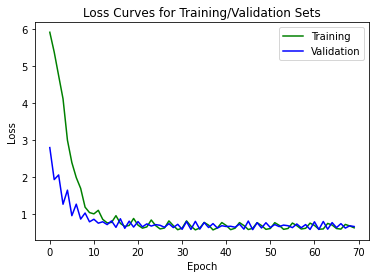

In [78]:
plot_loss_curves(history.history, figname="binary_classifier_alt.png")

---
## Testing

In [43]:
#creating test pos and test neg cutouts
num_negative = int(0.1*len(hf_neg)) +1
test_negative = np.zeros((num_negative, cutout_size, cutout_size, 5))
test_start = int(0.9*len(hf_neg))
test_end = len(hf_neg)
i = 0
for n in range(test_start, test_end):
    test_negative[i] = np.array(hf_neg.get(f"cutout{n}"))
    i += 1
    
test_positive = confirmed_cutouts[int(0.9*len(confirmed_cutouts)):]

In [44]:
#creating test set with both previous sets in them
test_cutouts = np.array(list(test_negative) + list(test_positive))
test_labels = np.array(list(np.zeros(len(test_negative), dtype=int)) + list(np.ones(len(test_positive), dtype=int)))
(test_cutouts, test_labels) = shuffle(test_cutouts, test_labels)

2/2 [==============================] - 0s 11ms/step - loss: 1.0271 - accuracy: 0.5000
Lowest 10 scores:
[array([0.579615], dtype=float32), array([0.6122171], dtype=float32), array([0.6313511], dtype=float32), array([0.6868477], dtype=float32), array([0.6912145], dtype=float32), array([0.6934072], dtype=float32), array([0.7082925], dtype=float32), array([0.7123458], dtype=float32), array([0.7123458], dtype=float32), array([0.7123458], dtype=float32)]

Highest 10 scores:

[array([0.9216108], dtype=float32), array([0.92593455], dtype=float32), array([0.9262707], dtype=float32), array([0.9264214], dtype=float32), array([0.9320164], dtype=float32), array([0.9383921], dtype=float32), array([0.9393043], dtype=float32), array([0.94037324], dtype=float32), array([0.9461174], dtype=float32), array([0.971046], dtype=float32)]
Confusion Matrix:
 [[29  0]
 [29  0]]
Test loss: 1.027
Test accuracy: 0.500000


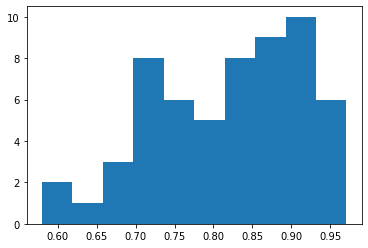

In [79]:
pred_label = evaluate_model(classifier, test_cutouts, test_labels)

---- 
# ROC curve
Smaller values on the x-axis of the plot indicate lower false positives and higher true negatives.
Larger values on the y-axis of the plot indicate higher true positives and lower false negatives.

In [23]:
from sklearn import metrics

In [80]:
fpr, tpr, thresholds = metrics.roc_curve(y_true = test_labels, y_score = pred_label)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(test_labels))]

In [81]:
ns_auc = metrics.roc_auc_score(test_labels, ns_probs)
lr_auc = metrics.roc_auc_score(test_labels, pred_label)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.529


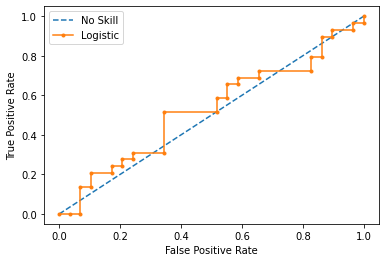

In [82]:
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = metrics.roc_curve(test_labels, ns_probs)
lr_fpr, lr_tpr, _ = metrics.roc_curve(test_labels, pred_label)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [60]:
hf_pos.close()
hf_neg.close()